# 1. Import thư viện và dữ liệu

In [2]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt


import warnings
import datetime


from boruta                  import BorutaPy
from sklearn.metrics         import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.decomposition   import PCA
from sklearn.preprocessing   import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

In [4]:
def mean_percentage_error(y, y_predict):
    return np.mean((y - y_predict) / y)
def mean_absolute_percentage_error(y, y_predict):
    return np.mean(np.abs((y - y_predict) / y))
def model_evaluation(model_name, y_test, y_predict):
    r2_test = r2_score(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error (y_test, y_predict)
    mape = mean_absolute_percentage_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    return pd.DataFrame({'Model Name': model_name,
                         'R2': r2_test,
                         'MAE': mae,
                         'MSE': mse,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

In [5]:
store_data = pd.read_csv('./Data Source/store.csv')
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train_data = pd.read_csv('./Data Source/train.csv', low_memory = False)
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
raw_data = pd.merge(store_data, train_data, how = 'left',on = 'Store')
raw_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1


- Do tài nguyên máy có hạn nên tôi chỉ lấy dữ liệu của năm 2014.

In [8]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.head()
first_data = raw_data[(raw_data['Date'] >= '2014-01-01') & (raw_data['Date'] < '2015-01-01')]
first_data = first_data.reset_index(drop=True)
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2014-12-31,2605,327,1,0,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2014-12-30,6466,703,1,0,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2014-12-29,6463,700,1,0,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2014-12-28,0,0,0,0,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,6,2014-12-27,6057,684,1,0,0,1


- Store: ID của mỗi cửa hàng;
- DayOfWeek: Ngày thứ bao nhiêu trong tuần (thứ 2 đến chủ nhật), thông thường các cửa hàng đóng cửa vào thứ bảy và chủ nhật;
- Date: Thời gian diễn ra hoạt động của cửa hàng;
- Sales: Doanh thu cho bất kỳ ngày nào (Giá trị chúng ta cần dự đoán);
- Customers: Số lượng khách hàng vào một ngày;
- Open: Chỉ báo xem cửa hàng có mở hay không (0: đóng cửa, 1: mở cửa);
- Promo: Cho biết cửa hàng có khuyến mãi vào ngày đó không (0: không có, 1: có);
- StateHoliday: Cho biết ngày lễ của tiểu bang. Trừ một vài ngoại lệ, thông thường các cửa hàng đều đóng cửa vào các ngày lễ của tiểu bang (a: nghỉ lễ, b: lễ Phục sinh, c: Giáng sinh, 0: không);
- SchoolHoliday: Cho biết liệu cửa hàng có bị ảnh hưởng bởi việc đóng cửa, nghỉ lễ của trường công lập không (0: không, 1: có);
- StoreType: Chỉ ra 4 mô hình cửa hàng khác nhau gồm a, b, c, d. Các loại cửa hàng khác nhau thì bán khác sản phẩm;
- Assortment: Mô tả cấp độ phân loại (a: cơ bản, b: bổ sung, c: mở rộng). Cho biết sự đa dạng trong các mặt hàng của cửa hàng;
- CompetitionDistance: Khoảng cách đến đối thủ cạnh tranh gần nhất (tính bằng mét);
- CompetitionOpenSinceMonth: Tháng mà đối thủ cạnh tranh gần nhất được mở
- CompetitionOpenSinceYear: Năm mà đối thủ cạnh tranh gần nhất được mở;
- Promo2: Chương trình khuyến mãi liên tục, liên tiếp cho một số cửa hàng (1: cửa hàng đang tiến hành khuyến mãi, 0: cửa hàng không tiến hành khuyến mãi);
- Promo2SinceWeek: Tuần khi cửa hàng bắt đầu tham gia Promo2;
- Promo2SinceYear: Năm khi cửa hàng bắt đầu tham gia Promo2;
- PromoInterval: Cho biết Promo2 chạy trong những tháng nhất định nào trong năm (khoảng thời gian liên tiếp promo2 được bắt đầu lại).

# 2. Phân tích và khám phá dữ liệu EDA

## 2.1 Khám phá dữ liệu

In [9]:
print(f'Số cột: {first_data.shape[1]}')
print(f'Số dòng: {first_data.shape[0]}')

Số cột: 18
Số dòng: 373855


In [10]:
first_data.duplicated().sum()

0

In [11]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373855 entries, 0 to 373854
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      373855 non-null  int64         
 1   StoreType                  373855 non-null  object        
 2   Assortment                 373855 non-null  object        
 3   CompetitionDistance        372944 non-null  float64       
 4   CompetitionOpenSinceMonth  254765 non-null  float64       
 5   CompetitionOpenSinceYear   254765 non-null  float64       
 6   Promo2                     373855 non-null  int64         
 7   Promo2SinceWeek            179711 non-null  float64       
 8   Promo2SinceYear            179711 non-null  float64       
 9   PromoInterval              179711 non-null  object        
 10  DayOfWeek                  373855 non-null  int64         
 11  Date                       373855 non-null  datetime

In [12]:
col = list(first_data.columns)
col.remove('CompetitionDistance')
col.remove('Date')
for i in col:
    print(f'Tập giá trị của cột {i} có ', first_data[i].nunique(), ' phần tử:', first_data[i].unique())

Tập giá trị của cột Store có  1115  phần tử: [   1    2    3 ... 1113 1114 1115]
Tập giá trị của cột StoreType có  4  phần tử: ['c' 'a' 'd' 'b']
Tập giá trị của cột Assortment có  3  phần tử: ['a' 'c' 'b']
Tập giá trị của cột CompetitionOpenSinceMonth có  12  phần tử: [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
Tập giá trị của cột CompetitionOpenSinceYear có  23  phần tử: [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Tập giá trị của cột Promo2 có  2  phần tử: [0 1]
Tập giá trị của cột Promo2SinceWeek có  24  phần tử: [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Tập giá trị của cột Promo2SinceYear có  7  phần tử: [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
Tập giá trị của cột PromoInterval có  3  phần tử: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
Tập giá trị của cột DayOfWeek có  7  phần tử: [3 2

In [13]:
first_data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Store,373855.0,559.170379,1.0,282.0,559.0,839.0,1115.0,321.969593
CompetitionDistance,372944.0,5473.399465,20.0,700.0,2330.0,6890.0,75860.0,7809.850736
CompetitionOpenSinceMonth,254765.0,7.219712,1.0,4.0,8.0,10.0,12.0,3.21458
CompetitionOpenSinceYear,254765.0,2008.727074,1900.0,2006.0,2010.0,2013.0,2015.0,5.632481
Promo2,373855.0,0.480697,0.0,0.0,0.0,1.0,1.0,0.499628
Promo2SinceWeek,179711.0,22.670783,1.0,13.0,18.0,37.0,50.0,14.014399
Promo2SinceYear,179711.0,2011.732977,2009.0,2011.0,2012.0,2013.0,2015.0,1.64308
DayOfWeek,373855.0,3.998462,1.0,2.0,4.0,6.0,7.0,1.998125
Date,373855,2014-06-23 23:34:53.191210496,2014-01-01 00:00:00,2014-03-25 00:00:00,2014-06-17 00:00:00,2014-09-23 00:00:00,2014-12-31 00:00:00,NaN
Sales,373855.0,5833.290704,0.0,3760.0,5794.0,7941.0,38037.0,3883.887435


## 2.2 Trực quan hóa dữ liệu

In [14]:
sns.set_theme()

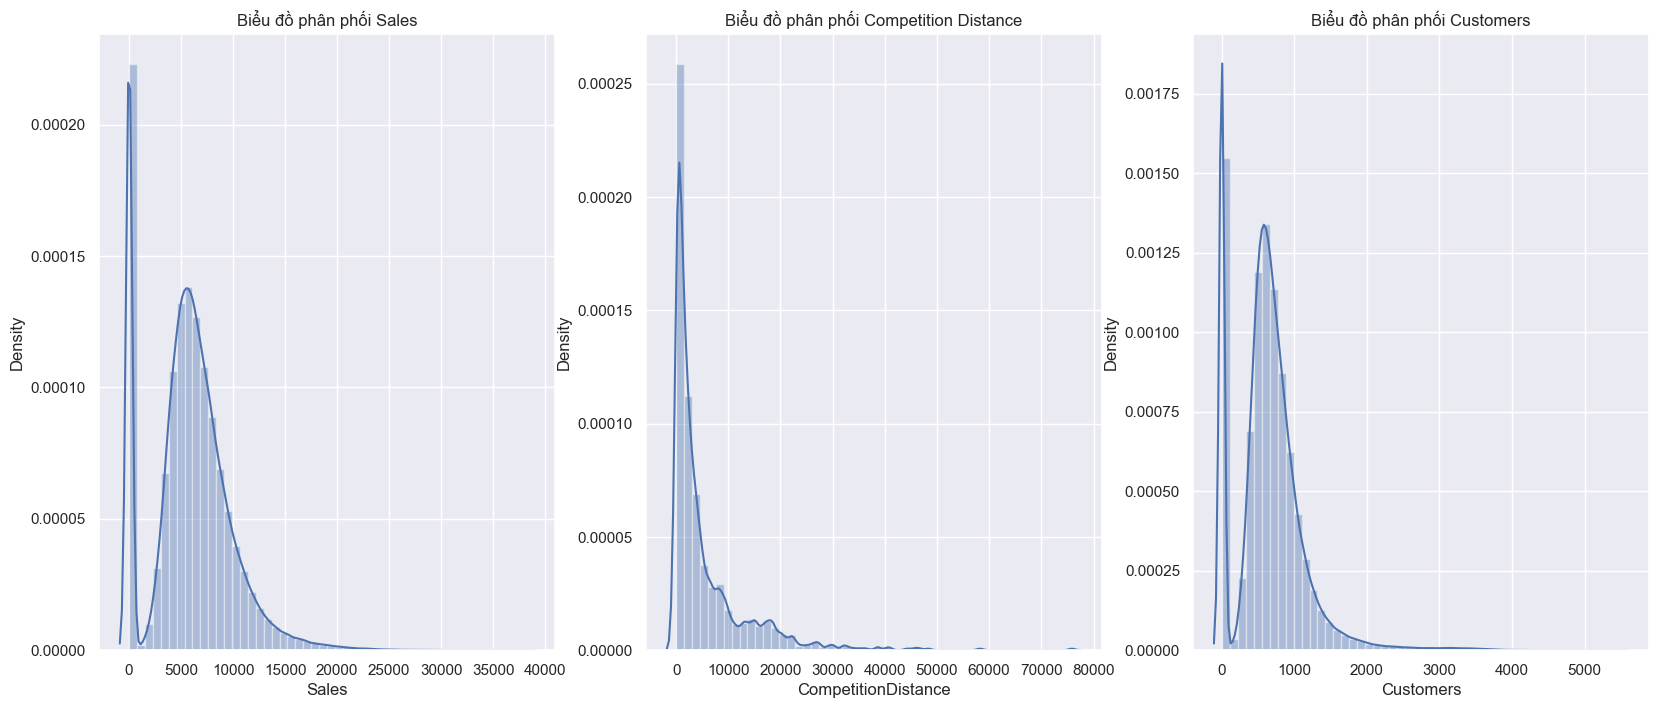

In [15]:
plt.figure(figsize=(20, 8))

plt.subplot(1,3,1)
sns.distplot(first_data['Sales'])
plt.title('Biểu đồ phân phối Sales');

plt.subplot(1,3,2)
sns.distplot(first_data['CompetitionDistance'])
plt.title('Biểu đồ phân phối Competition Distance');

plt.subplot(1,3,3)
sns.distplot(first_data['Customers'])
plt.title('Biểu đồ phân phối Customers');

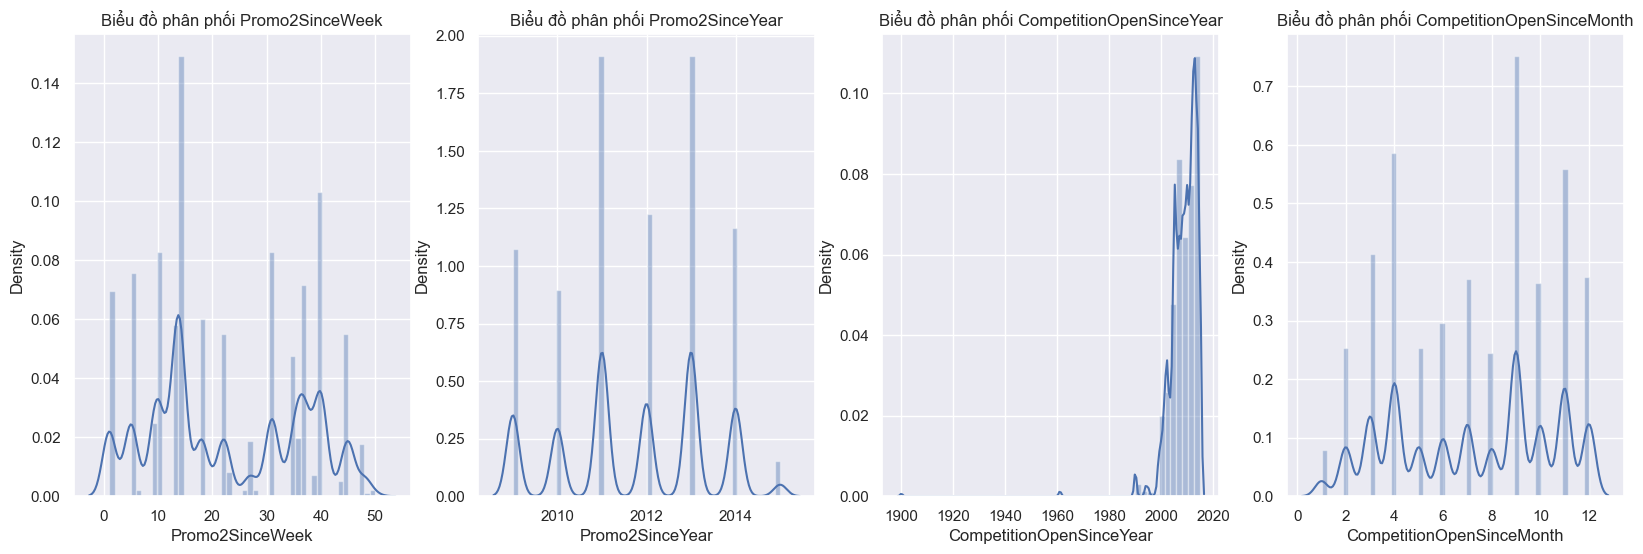

In [16]:
plt.figure(figsize=(20, 6))

plt.subplot(1,4,1)
sns.distplot(first_data['Promo2SinceWeek'])
plt.title('Biểu đồ phân phối Promo2SinceWeek');

plt.subplot(1,4,2)
sns.distplot(first_data['Promo2SinceYear'])
plt.title('Biểu đồ phân phối Promo2SinceYear');

plt.subplot(1,4,3)
sns.distplot(first_data['CompetitionOpenSinceYear'])
plt.title('Biểu đồ phân phối CompetitionOpenSinceYear');

plt.subplot(1,4,4)
sns.distplot(first_data['CompetitionOpenSinceMonth'])
plt.title('Biểu đồ phân phối CompetitionOpenSinceMonth');

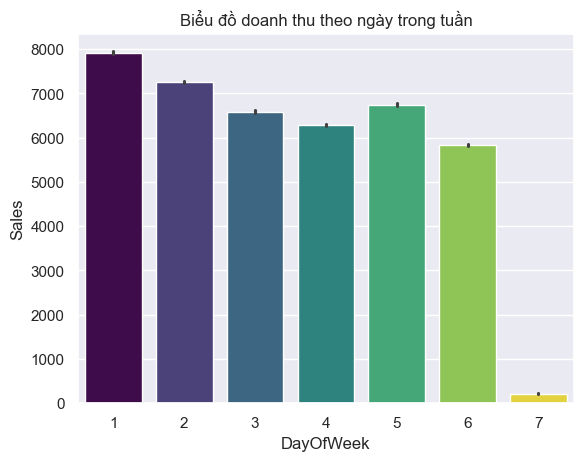

In [17]:
sns.barplot(data = first_data, x = 'DayOfWeek', y = 'Sales', palette = 'viridis', hue = 'DayOfWeek', legend = False).set(title='Biểu đồ doanh thu theo ngày trong tuần');

- Thực hiện tách cột Day từ cột Date để trực quan hóa doanh thu từng ngày trong tháng

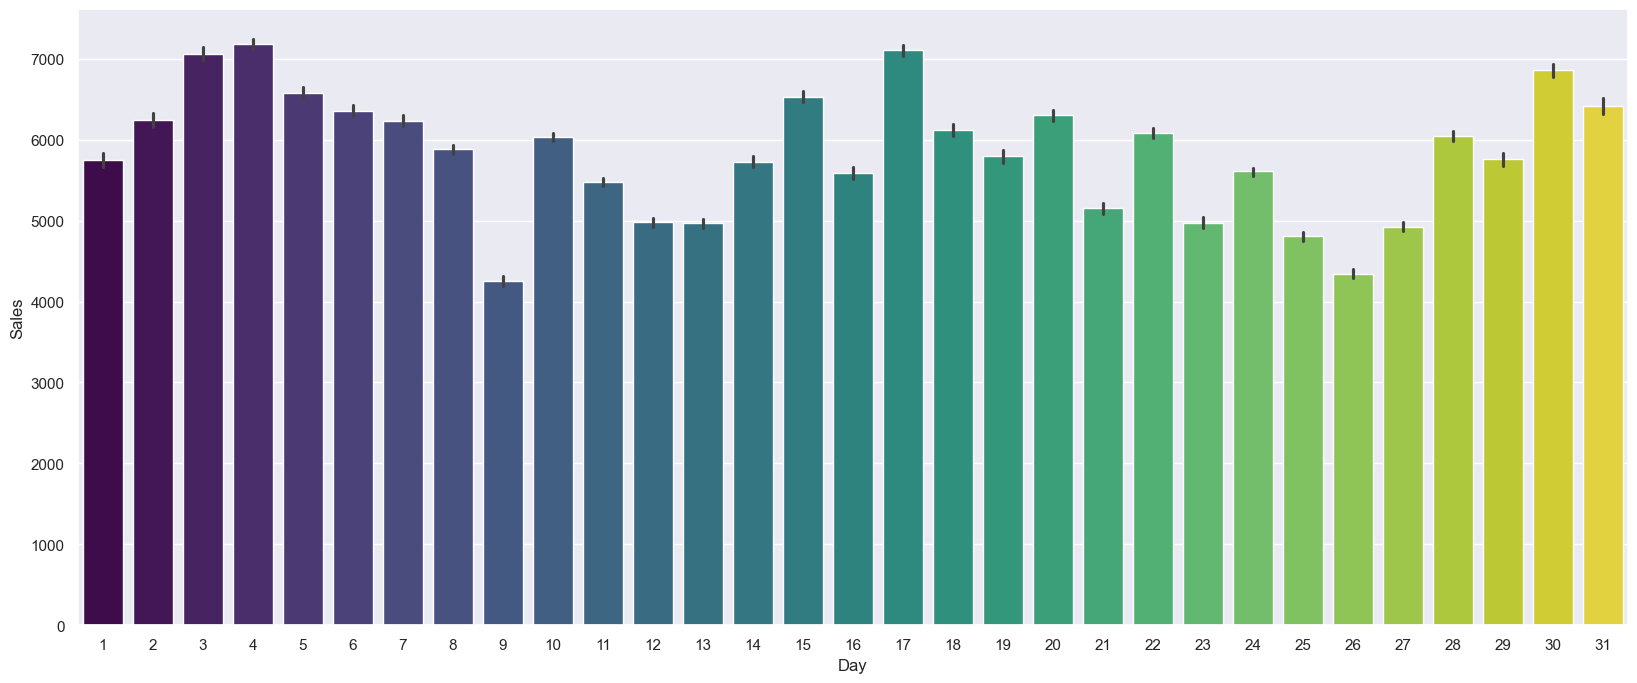

In [18]:
first_data['Day'] = first_data['Date'].dt.day
data_day = first_data[['Day', 'Sales']].groupby('Day').sum().reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(data = first_data, x = 'Day', y = 'Sales', hue = 'Day', palette = 'viridis', legend = False);

- Thực hiện tách cột Day từ cột Date để trực quan hóa doanh thu từng tháng trong năm

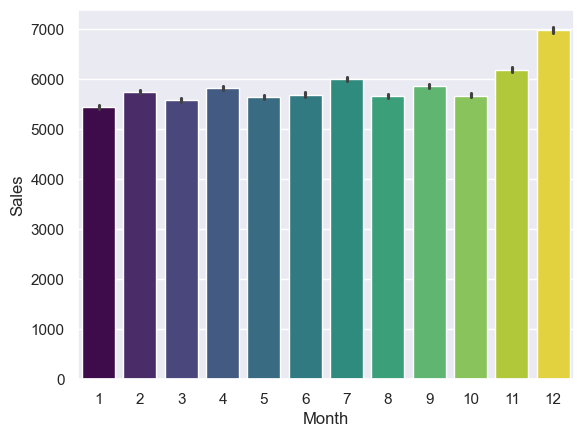

In [19]:
first_data['Month'] = first_data['Date'].dt.month
sns.barplot(data = first_data, x = 'Month', y = 'Sales', hue = 'Month', palette = 'viridis', legend = False);

In [20]:
line_data = pd.pivot_table(first_data, index = 'Month', columns = 'StoreType', values = 'Sales', observed = False)
line_data.columns = ['a', 'b', 'c', 'd']
line_data.head()

,a,b,c,d
Month,,,,
1,5401.431197,9408.425047,5335.615083,5331.223211
2,5701.070301,9958.539916,5646.799469,5612.359811
3,5550.226717,9831.172676,5437.254795,5498.180386
4,5778.743023,10408.949020,5705.355180,5703.116571
5,5551.810524,10541.174573,5563.590453,5562.144698


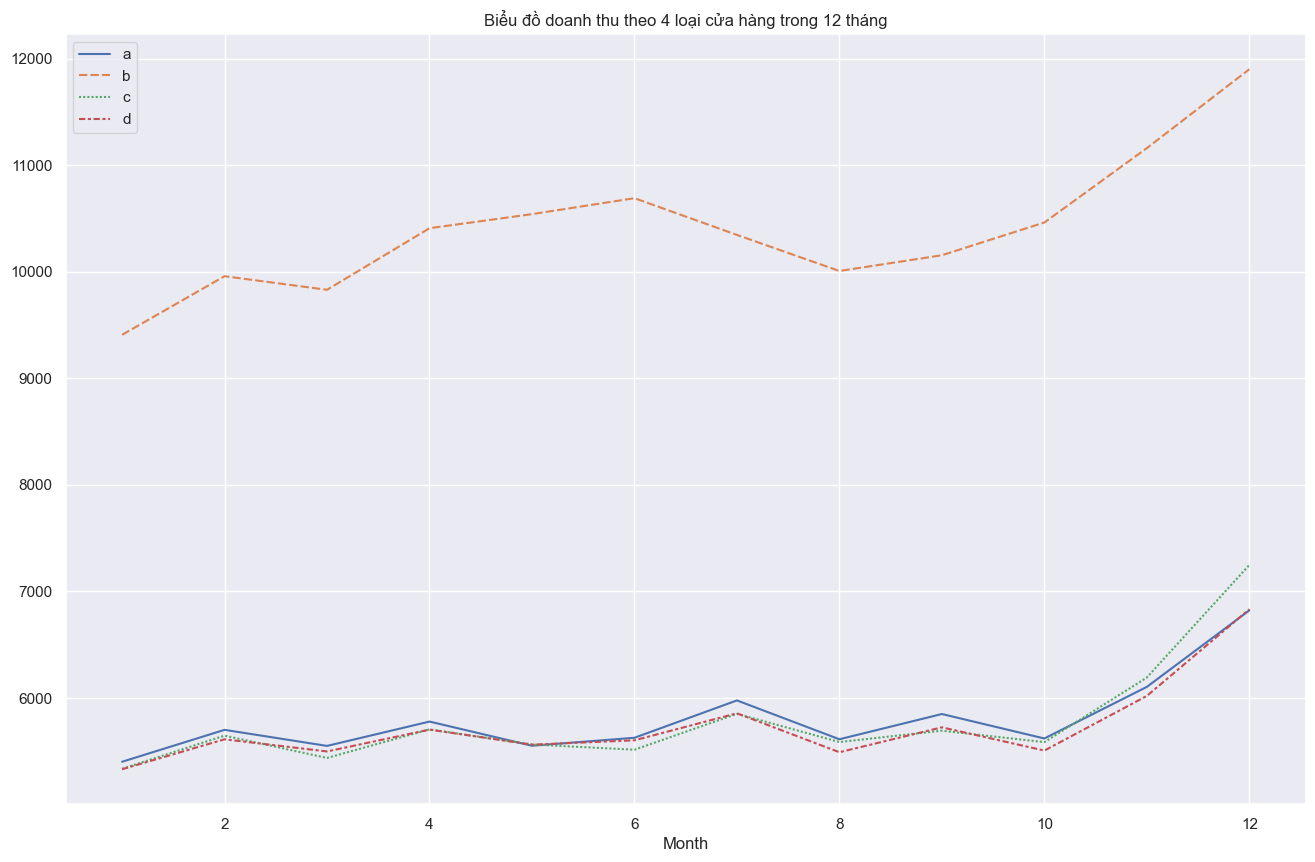

In [21]:
plt.figure(figsize=(16, 10))
sns.lineplot(data = line_data).set(title='Biểu đồ doanh thu theo 4 loại cửa hàng trong 12 tháng');
plt.show()

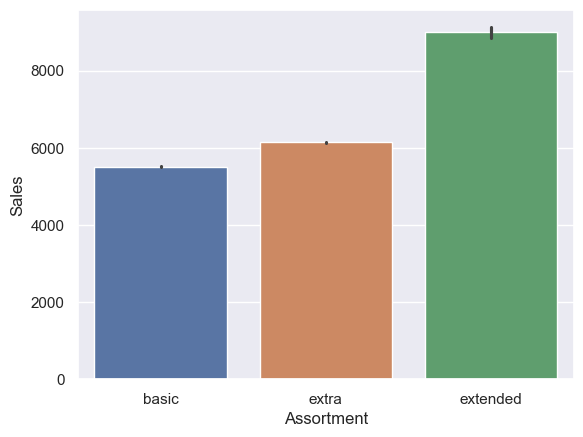

In [22]:
sns.barplot(data=first_data, x="Assortment", y="Sales", hue="Assortment", legend = False)
plt.xticks(ticks=[0, 1, 2], labels=["basic", "extra", "extended"])
plt.show()

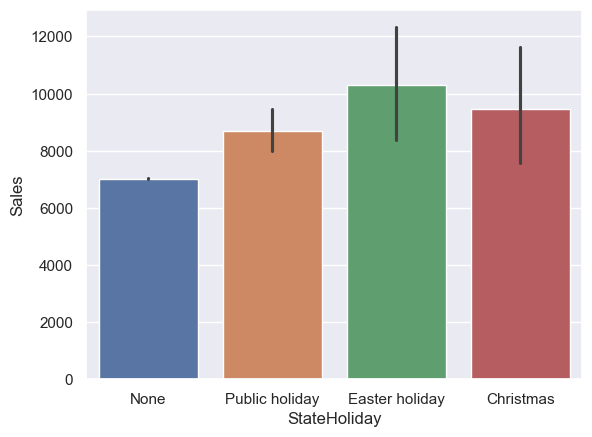

In [23]:
data_SH = first_data[first_data['Sales'] > 0]
sns.barplot(data=data_SH, x="StateHoliday", y="Sales", hue="StateHoliday", legend = False)
plt.xticks(ticks=[0, 1, 2, 3], labels=["None", "Public holiday", "Easter holiday", "Christmas"])
plt.show()

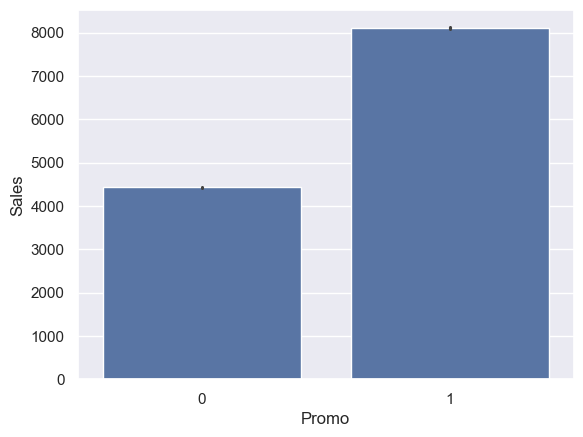

In [24]:
sns.barplot(data = first_data, x = 'Promo', y = 'Sales');

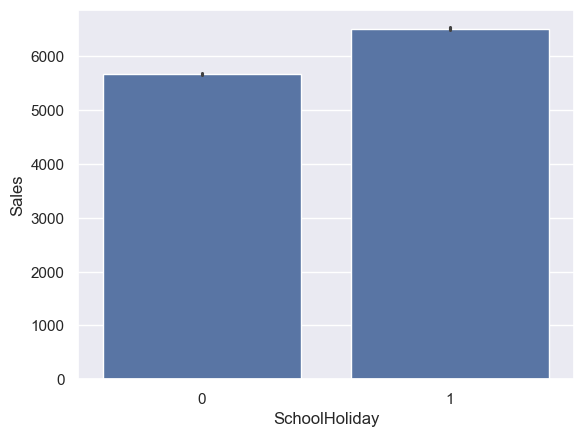

In [25]:
sns.barplot(data = first_data, x = 'SchoolHoliday', y = 'Sales');

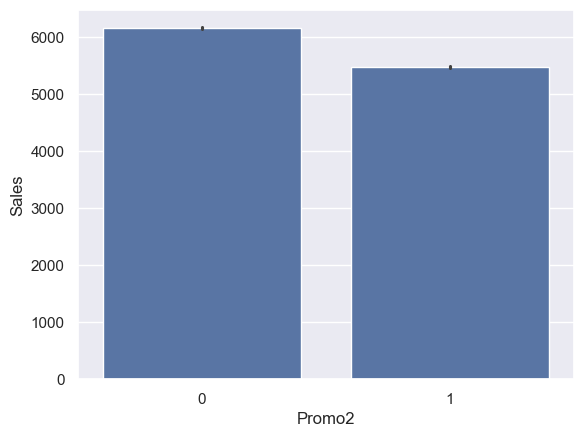

In [26]:
sns.barplot(data = first_data, x = 'Promo2', y = 'Sales');

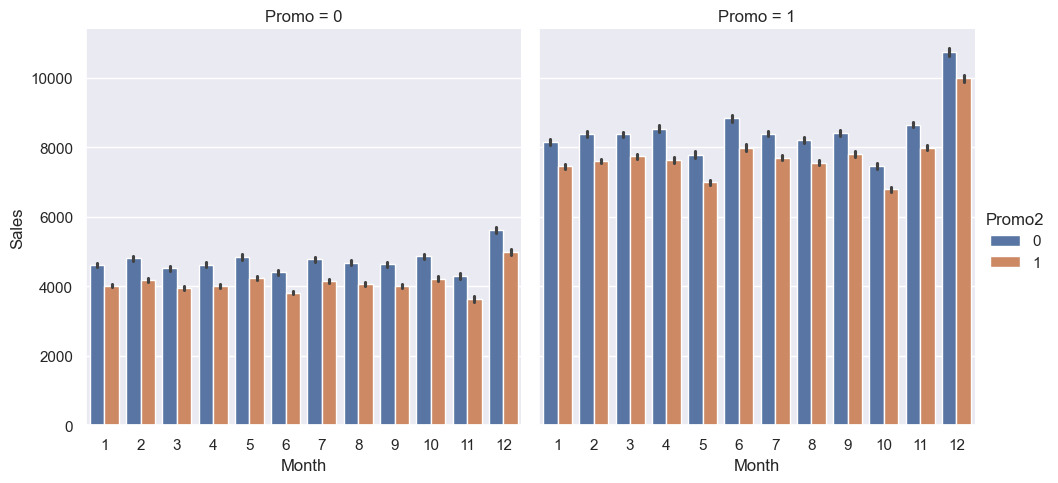

In [27]:
sns.catplot(data = first_data, x = "Month", y = "Sales", col='Promo', hue = 'Promo2', kind='bar');

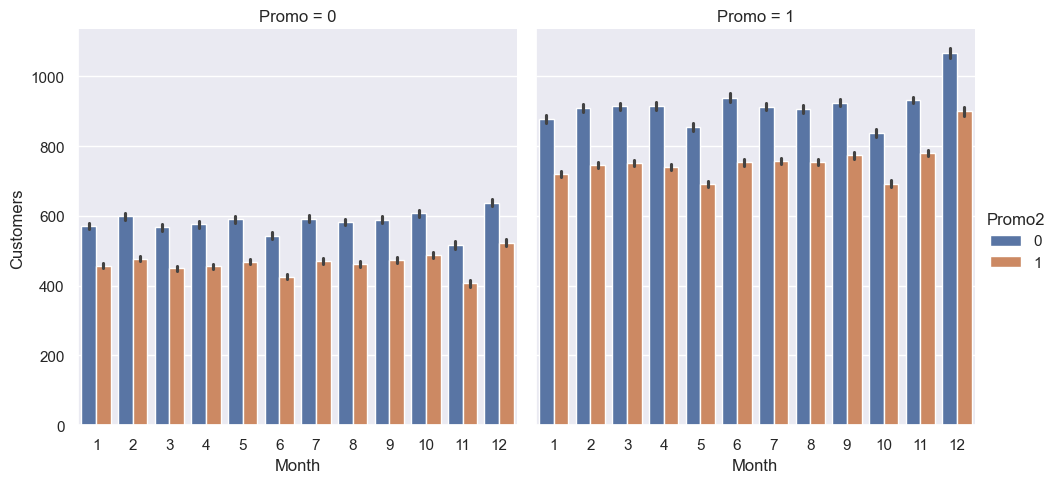

In [28]:
sns.catplot(data = first_data, x = "Month", y = "Customers", col = 'Promo', hue = 'Promo2', kind = 'bar');

- Qua 2 biểu đồ cho ta thấy chương trình khuyến mãi liên tục không làm tăng doanh thu và lượng khách hàng cho cửa hàng.

# 3. Tiền xử lý dữ liệu

## 3.1 Filling missing data và loại bỏ outliers

In [29]:
first_data.isna().sum()

Store                             0
StoreType                         0
Assortment                        0
CompetitionDistance             911
CompetitionOpenSinceMonth    119090
CompetitionOpenSinceYear     119090
Promo2                            0
Promo2SinceWeek              194144
Promo2SinceYear              194144
PromoInterval                194144
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Day                               0
Month                             0
dtype: int64

In [30]:
first_data['CompetitionDistance'].describe()

count    372944.000000
mean       5473.399465
std        7809.850736
min          20.000000
25%         700.000000
50%        2330.000000
75%        6890.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

- Tôi cho rằng khoảng cách đối thủ cạnh tranh là một đặc trưng quan trọng và sẽ có các đối thủ ở xa mà cửa hàng không đề cập, nên tôi quyết định điền các giá trị còn trống bằng 150.000m.

In [32]:
first_data.update(first_data['CompetitionDistance'].fillna(150000))

- CompetitionOpenSinceMonth, CompetitionOpenSinceYear đều được điền là tháng và năm hiện tại

In [31]:
first_data.update(first_data['CompetitionOpenSinceMonth'].fillna(first_data['Date'].dt.month))
first_data.update(first_data['CompetitionOpenSinceYear'].fillna(first_data['Date'].dt.year))
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2014-12-31,2605,327,1,0,0,1,31,12
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2014-12-30,6466,703,1,0,0,1,30,12
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2014-12-29,6463,700,1,0,0,1,29,12
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2014-12-28,0,0,0,0,0,1,28,12
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,6,2014-12-27,6057,684,1,0,0,1,27,12


- Đối với các cửa hàng không có chương trình khuyến mãi liên tục thì tôi điền Promo2SinceWeek, Promo2SinceYear bằng 0.

In [33]:
first_data.update(first_data['Promo2SinceWeek'].fillna(0))
first_data.update(first_data['Promo2SinceYear'].fillna(0))
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,3,2014-12-31,2605,327,1,0,0,1,31,12
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,2,2014-12-30,6466,703,1,0,0,1,30,12
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,1,2014-12-29,6463,700,1,0,0,1,29,12
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,7,2014-12-28,0,0,0,0,0,1,28,12
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,6,2014-12-27,6057,684,1,0,0,1,27,12


- Thực hiện chuyển đổi đặc trưng PromoInterval thành Promo2 để biết được vào ngày đó có chương trình khuyến mãi liên tục không.

In [34]:
first_data = first_data.copy()
first_data['MonthForPro2'] = first_data['Date'].dt.strftime('%b')
first_data['IsPromo2'] = first_data[['PromoInterval', 'MonthForPro2']].apply(lambda x: x['MonthForPro2'] in str(x['PromoInterval']).split(','), axis = 1).astype('int64')
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,MonthForPro2,IsPromo2
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,3,2014-12-31,2605,327,1,0,0,1,31,12,Dec,0
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,2,2014-12-30,6466,703,1,0,0,1,30,12,Dec,0
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,1,2014-12-29,6463,700,1,0,0,1,29,12,Dec,0
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,7,2014-12-28,0,0,0,0,0,1,28,12,Dec,0
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,6,2014-12-27,6057,684,1,0,0,1,27,12,Dec,0


In [35]:
first_data.isna().sum()

Store                             0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                194144
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Day                               0
Month                             0
MonthForPro2                      0
IsPromo2                          0
dtype: int64

- Trong bài này tôi chỉ phân tích và dự đoán các ngày mở cửa và các ngày có doanh thu hơn hơn 0.

In [36]:
first_data = first_data[(first_data['Open'] != 0) & (first_data['Sales'] > 0)]
first_data.drop('Open', axis = 1, inplace = True)

- Tìm  kiếm các giá trị ngoại lai.

Số lượng record outliers:  4908


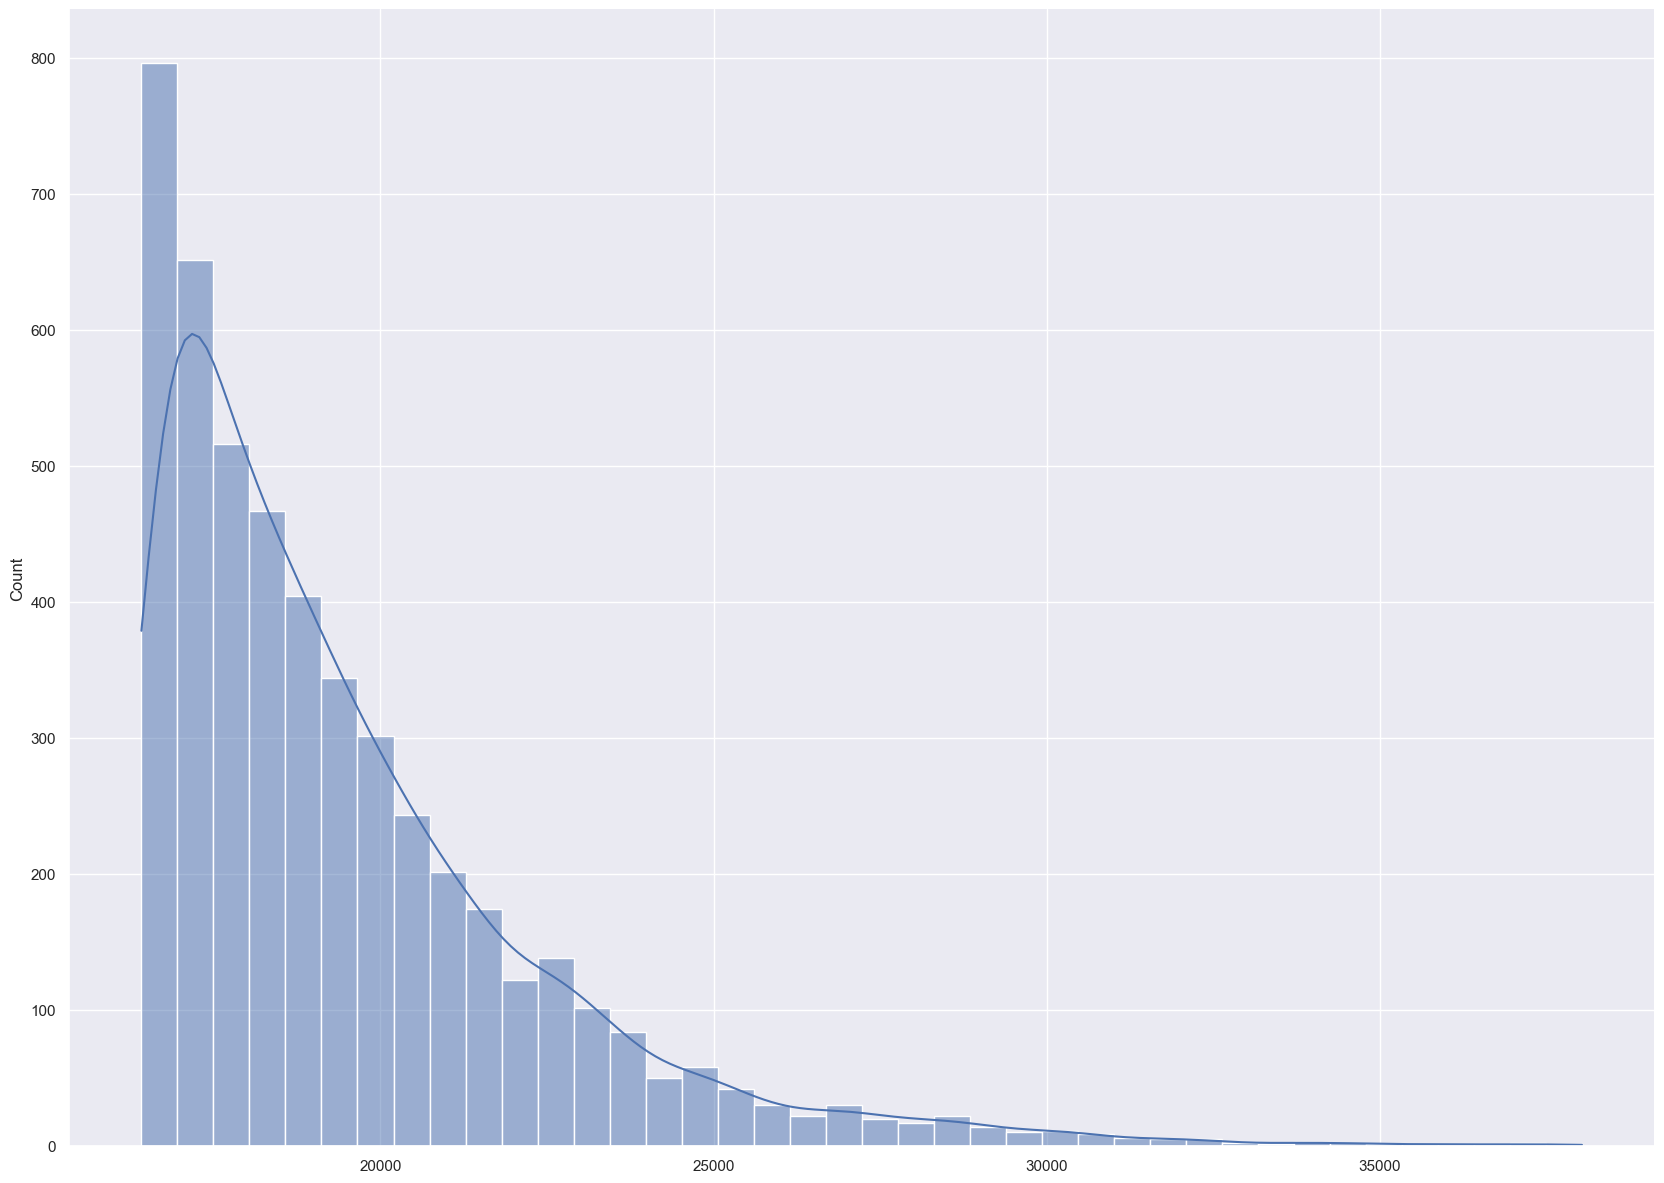

In [37]:
mean_sales = first_data['Sales'].mean()
std_sales = first_data['Sales'].std()
outliers = []
threshold = 3
for i in first_data['Sales']:
    z_score = (i - mean_sales) / std_sales
    if (z_score > threshold):
        outliers.append(i)
print('Số lượng record outliers: ', len(outliers))
sns.displot(x = outliers, bins = 40, kde = True, height = 12, aspect = 1.4);

In [38]:
sales_than_25k = first_data[first_data['Sales'] > 25000]
print('Phần trăm giá trị Sales > 25000 trong tập dữ liệu: %.3f%% ' %((len(sales_than_25k)/len(first_data))*100))

Phần trăm giá trị Sales > 25000 trong tập dữ liệu: 0.084% 


- Các giá trị ngoại lai Sales > 25.000 trong tập dữ liệu chiếm 1 phần nhỏ. Quyết định loại bỏ.

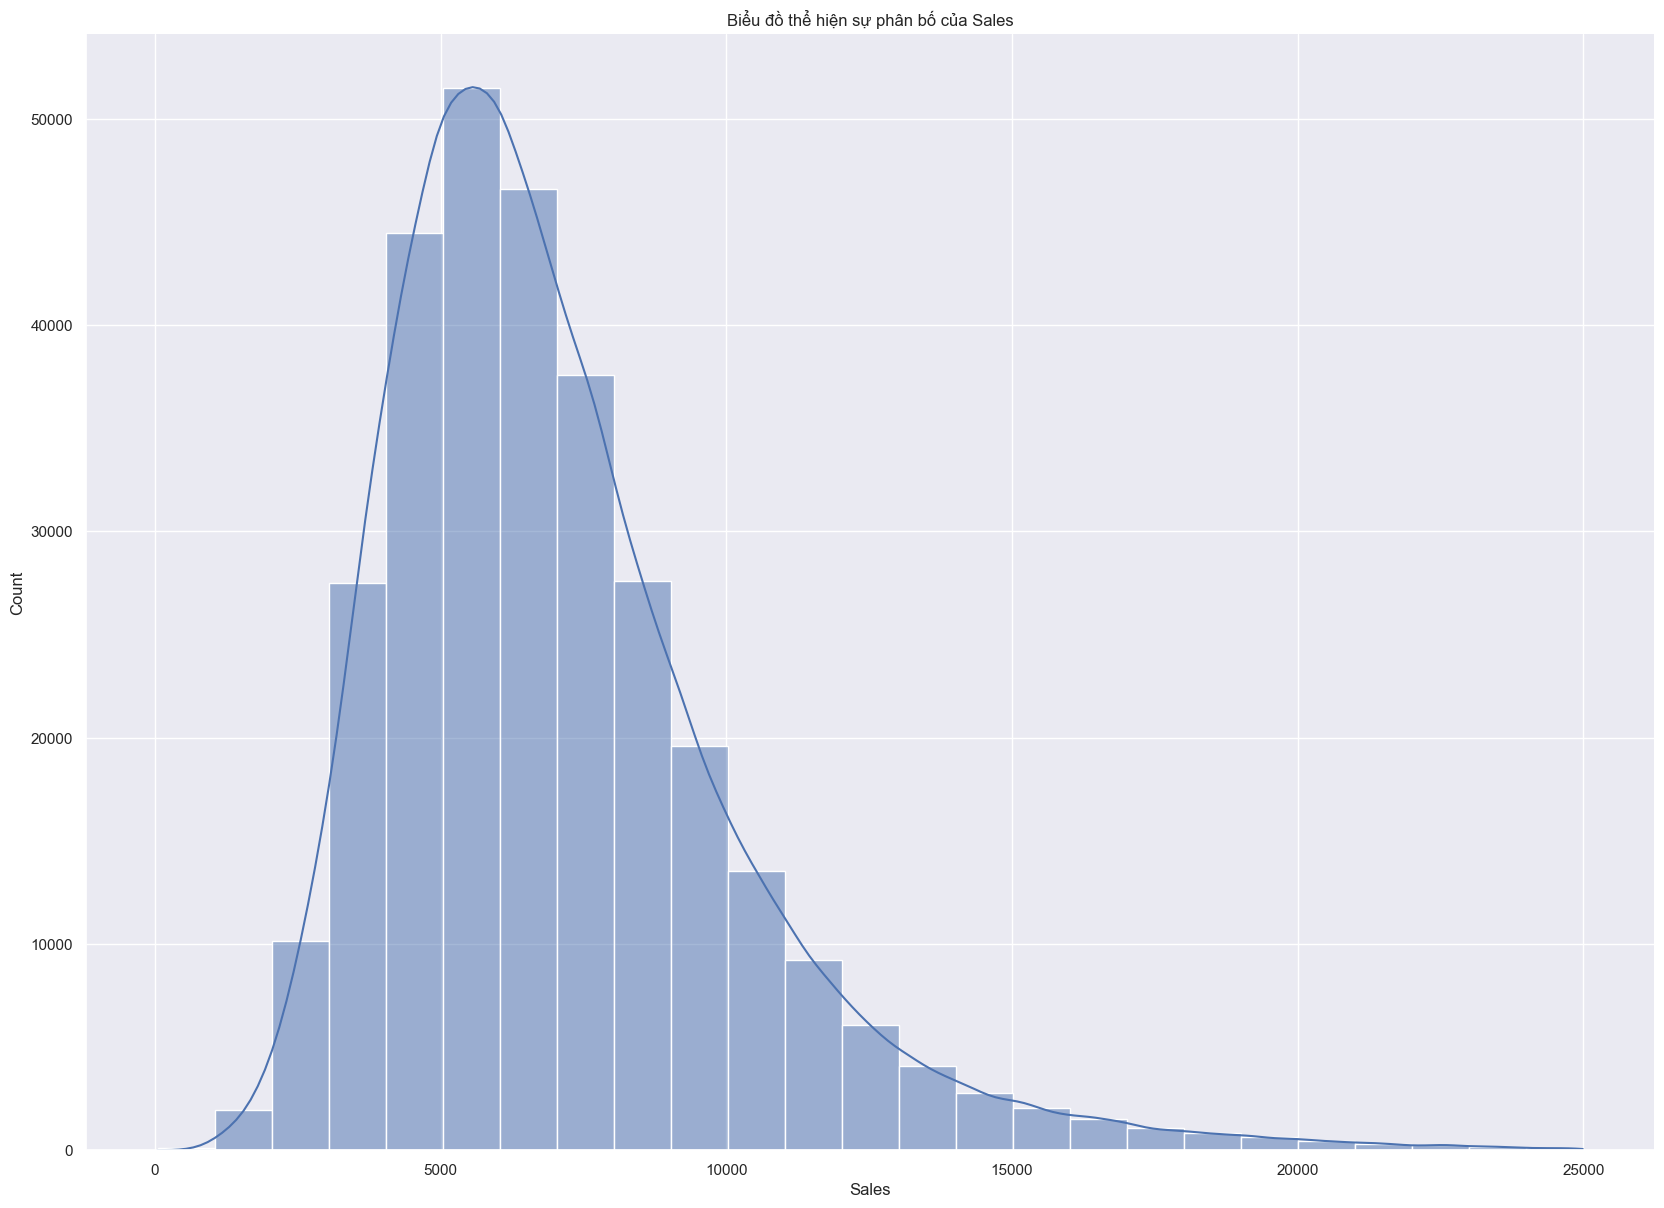

In [39]:
first_data.drop(first_data.loc[first_data['Sales'] > 25000].index,inplace=True)
sns.displot(first_data,x='Sales', kde = True, bins=25, height = 12, aspect = 1.4).set(title='Biểu đồ thể hiện sự phân bố của Sales');

## 3.2 Định dạng lại kiểu dữ liệu

In [40]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310124 entries, 0 to 373853
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      310124 non-null  int64         
 1   StoreType                  310124 non-null  object        
 2   Assortment                 310124 non-null  object        
 3   CompetitionDistance        310124 non-null  float64       
 4   CompetitionOpenSinceMonth  310124 non-null  float64       
 5   CompetitionOpenSinceYear   310124 non-null  float64       
 6   Promo2                     310124 non-null  int64         
 7   Promo2SinceWeek            310124 non-null  float64       
 8   Promo2SinceYear            310124 non-null  float64       
 9   PromoInterval              148474 non-null  object        
 10  DayOfWeek                  310124 non-null  int64         
 11  Date                       310124 non-null  datetime64[ns

In [41]:
first_data['CompetitionOpenSinceMonth'] = first_data['CompetitionOpenSinceMonth'].astype('int')
first_data['CompetitionOpenSinceYear'] = first_data['CompetitionOpenSinceYear'].astype('int')
first_data['Promo2SinceWeek'] = first_data['Promo2SinceWeek'].astype('int')
first_data['Promo2SinceYear'] = first_data['Promo2SinceYear'].astype('int')
first_data['CompetitionDistance'] = first_data['CompetitionDistance'].astype('int')
first_data['StoreType'] = first_data['StoreType'].astype('category')
first_data['Assortment'] = first_data['Assortment'].astype('category')
first_data['StateHoliday'] = first_data['StateHoliday'].astype('category')

In [42]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310124 entries, 0 to 373853
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      310124 non-null  int64         
 1   StoreType                  310124 non-null  category      
 2   Assortment                 310124 non-null  category      
 3   CompetitionDistance        310124 non-null  int32         
 4   CompetitionOpenSinceMonth  310124 non-null  int32         
 5   CompetitionOpenSinceYear   310124 non-null  int32         
 6   Promo2                     310124 non-null  int64         
 7   Promo2SinceWeek            310124 non-null  int32         
 8   Promo2SinceYear            310124 non-null  int32         
 9   PromoInterval              148474 non-null  object        
 10  DayOfWeek                  310124 non-null  int64         
 11  Date                       310124 non-null  datetime64[ns

## 3.3 Mã hóa dữ liệu phân loại

- Có 3 đặc trưng có kiểu dữ liệu category là: Assortment, StoreType, StateHoliday;
- Label encoder: Assortment, StoreType.
- Dummy encoding: StateHoliday.

In [43]:
label_encoder = LabelEncoder()
first_data['Assortment'] = label_encoder.fit_transform(first_data['Assortment'])
first_data['StoreType'] = label_encoder.fit_transform(first_data['StoreType'])
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,MonthForPro2,IsPromo2
0,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-31,2605,327,0,0,1,31,12,Dec,0
1,1,2,0,1270,9,2008,0,0,0,NaN,2,2014-12-30,6466,703,0,0,1,30,12,Dec,0
2,1,2,0,1270,9,2008,0,0,0,NaN,1,2014-12-29,6463,700,0,0,1,29,12,Dec,0
4,1,2,0,1270,9,2008,0,0,0,NaN,6,2014-12-27,6057,684,0,0,1,27,12,Dec,0
7,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-24,3659,421,0,0,1,24,12,Dec,0


In [44]:
dummies_data = pd.get_dummies(first_data['StateHoliday'], prefix = 'StateHoliday', dtype = np.int64)
dummies_data = dummies_data.rename(columns = {'StateHoliday_a': 'PublicHoliday', 'StateHoliday_b': 'EasterHoliday', 'StateHoliday_c': 'Christmas'})
first_data = pd.concat([first_data, dummies_data], axis=1)
first_data.drop(columns = ['StateHoliday_0'], inplace = True)
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,MonthForPro2,IsPromo2,PublicHoliday,EasterHoliday,Christmas
0,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-31,2605,327,0,0,1,31,12,Dec,0,0,0,0
1,1,2,0,1270,9,2008,0,0,0,NaN,2,2014-12-30,6466,703,0,0,1,30,12,Dec,0,0,0,0
2,1,2,0,1270,9,2008,0,0,0,NaN,1,2014-12-29,6463,700,0,0,1,29,12,Dec,0,0,0,0
4,1,2,0,1270,9,2008,0,0,0,NaN,6,2014-12-27,6057,684,0,0,1,27,12,Dec,0,0,0,0
7,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-24,3659,421,0,0,1,24,12,Dec,0,0,0,0


## 3.4 Chuẩn hóa dữ liệu

In [45]:
train_data = first_data.copy()

- Ở đặc trưng Customers là 1 giá trị không thể biết trước, nên tôi quyết định chuyển thành trung bình lượng khách hàng cho các cửa hàng.

In [46]:
train_data['MeanCustomers'] = train_data.groupby('Store')['Customers'].transform('mean')

- Dựa vào phần: 2. Phân tích và khám phá dữ liệu EDA, không có đặc trưng nào có phân phối chuẩn, tôi thực hiện tính Z-Score để xác định ngoại lai để lựa chọn phương pháp chuẩn hóa dữ liệu phù hợp.

In [47]:
mean_PW = train_data['Promo2SinceWeek'].mean()
std_PW = train_data['Promo2SinceWeek'].std()
outliers_PW = []
threshold = 3
for i in train_data['Promo2SinceWeek']:
    z_score = (i - mean_PW) / std_PW
    if (z_score > threshold):
        outliers_PW.append(i)
print('Số lượng record outliers(Promo2SinceWeek): ', len(outliers_PW))

mean_PY = train_data['Promo2SinceYear'].mean()
std_PY = train_data['Promo2SinceYear'].std()
outliers_PY = []
threshold = 3
for i in train_data['Promo2SinceYear']:
    z_score = (i - mean_PY) / std_PY
    if (z_score > threshold):
        outliers_PY.append(i)
print('Số lượng record outliers(Promo2SinceYear): ', len(outliers_PY))

mean_COSM = train_data['CompetitionOpenSinceMonth'].mean()
std_COSM = train_data['CompetitionOpenSinceMonth'].std()
outliers_COSM = []
threshold = 3
for i in train_data['CompetitionOpenSinceMonth']:
    z_score = (i - mean_COSM) / std_COSM
    if (z_score > threshold):
        outliers_COSM.append(i)
print('Số lượng record outliers(CompetitionOpenSinceMonth): ', len(outliers_COSM))

mean_COSY = train_data['CompetitionOpenSinceYear'].mean()
std_COSY = train_data['CompetitionOpenSinceYear'].std()
outliers_COSY = []
threshold = 3
for i in train_data['CompetitionOpenSinceYear']:
    z_score = (i - mean_COSY) / std_COSY
    if (z_score > threshold):
        outliers_COSY.append(i)
print('Số lượng record outliers(CompetitionOpenSinceYear): ', len(outliers_COSY))

mean_MC = train_data['MeanCustomers'].mean()
std_MC = train_data['MeanCustomers'].std()
outliers_MC = []
threshold = 3
for i in train_data['MeanCustomers']:
    z_score = (i - mean_MC) / std_MC
    if (z_score > threshold):
        outliers_MC.append(i)
print('Số lượng record outliers(MeanCustomers): ', len(outliers_MC))

Số lượng record outliers(Promo2SinceWeek):  0
Số lượng record outliers(Promo2SinceYear):  0
Số lượng record outliers(CompetitionOpenSinceMonth):  0
Số lượng record outliers(CompetitionOpenSinceYear):  0
Số lượng record outliers(MeanCustomers):  5745


- CompetitionDistance khi điền giá trị null tôi đã điền giá trị ngoại lai nên tôi dùng RobustScaler, tương tự với MeanCustomers.
- CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear: không tồn tại ngoại lai nên sử dụng MiMaxScaler.

In [49]:
rb = RobustScaler()
ms = MinMaxScaler()
train_data['CompetitionDistance'] = rb.fit_transform(train_data[['CompetitionDistance']])
train_data['CompetitionOpenSinceMonth'] = ms.fit_transform(train_data[['CompetitionOpenSinceMonth']])
train_data['CompetitionOpenSinceYear'] = ms.fit_transform(train_data[['CompetitionOpenSinceYear']])
train_data['Promo2SinceWeek'] = ms.fit_transform(train_data[['Promo2SinceWeek']])
train_data['Promo2SinceYear'] = ms.fit_transform(train_data[['Promo2SinceYear']])
train_data['MeanCustomers'] = rb.fit_transform(train_data[['MeanCustomers']])

- Sử dụng Sin, Cos với Day và Month để bảo toàn tính chu kỳ của đặc trưng.

In [50]:
# Day of week
train_data['DayOfWeekSin'] = train_data['DayOfWeek'].apply(lambda x : np.sin(x * (2 * np.pi/7)))
train_data['DayOfWeekCos'] = train_data['DayOfWeek'].apply(lambda x : np.cos(x * (2 * np.pi/7)))

# Day
train_data['DaySin'] = train_data['Day'].apply(lambda x : np.sin(x * (2 * np.pi/31)))
train_data['DayCos'] = train_data['Day'].apply(lambda x : np.cos(x * (2 * np.pi/31)))

# Month
train_data['MonthSin'] = train_data['Month'].apply(lambda x : np.sin(x * (2 * np.pi/12)))
train_data['MonthCos'] = train_data['Month'].apply(lambda x : np.cos(x * (2 * np.pi/12)))

## 3.5 Lựa chọn đặc trưng

In [51]:
train_data.set_index('Date', inplace=True)

In [52]:
train_data.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Sales', 'Customers', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Day',
       'Month', 'MonthForPro2', 'IsPromo2', 'PublicHoliday', 'EasterHoliday',
       'Christmas', 'MeanCustomers', 'DayOfWeekSin', 'DayOfWeekCos', 'DaySin',
       'DayCos', 'MonthSin', 'MonthCos'],
      dtype='object')

- Loại bỏ các đặc trưng đã được chuyển đổi.

In [53]:
col_drop = ['PromoInterval', 'MonthForPro2', 'Customers', 'DayOfWeek', 'Day', 'Month', 'StateHoliday']
train_data.drop(columns = col_drop, axis = 1, inplace = True)

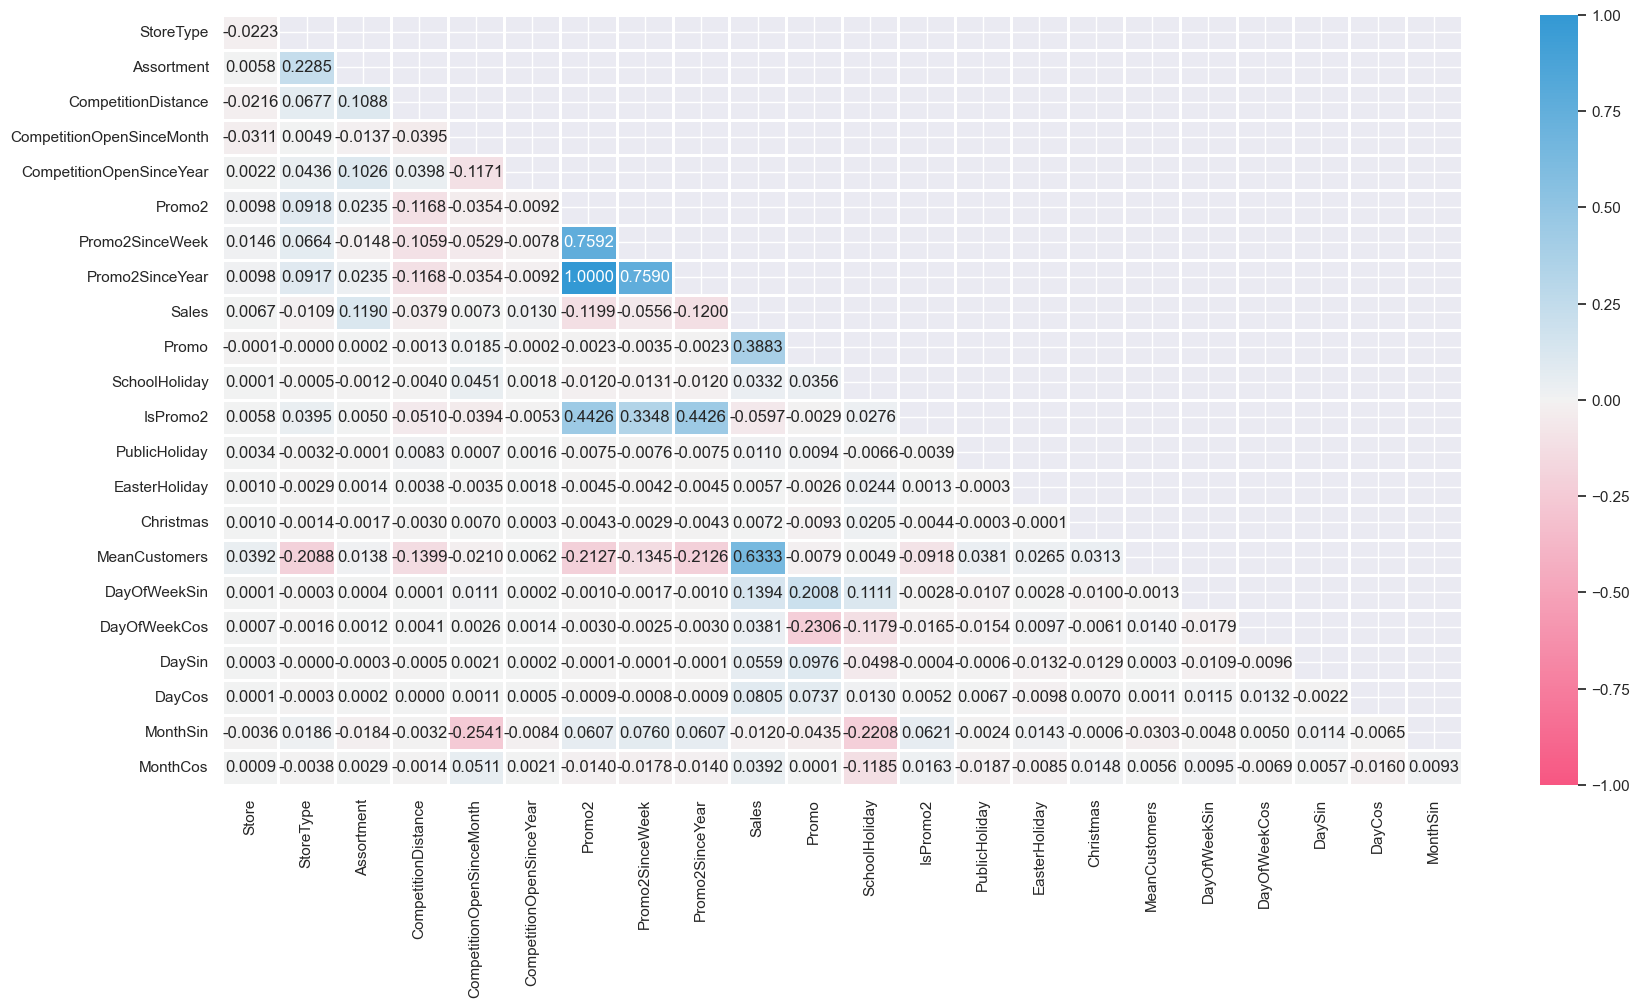

In [54]:
corr_data = train_data.corr()
corr_one = np.ones_like(corr_data, dtype = bool)
one_mask = np.triu(corr_one)
corr_data = corr_data.iloc[1:,:-1]
one_mask = one_mask[1:,:-1]

fig, ax = plt.subplots(figsize = (20, 10))
cmap = sns.diverging_palette(0, 239, 90, 60, as_cmap = True)
# 'BrBG'
sns.heatmap(data = corr_data, mask = one_mask, annot = True, fmt = '.4f', cmap = cmap, vmin = -1, vmax = 1, linecolor = 'white', linewidths = 1);

- Nhìn vào Heatmap ta thấy EasterHoliday có tương quan thấp nhất đối với biến mục tiêu Sales, quyết định bỏ.

In [55]:
train_data.drop('EasterHoliday', axis = 1, inplace = True)

- Chia tập dữ liệu train và test.

In [56]:
x_train, x_test, y_train, y_test = train_test_split(train_data.drop(['Sales'],axis = 1), train_data['Sales'], test_size = 0.2, random_state = 42)

# 4. Machine Learning Modelling

## 4.1 Mô hình Linear Regression

In [57]:
lrr = LinearRegression()
lrr.fit(x_train, y_train)
y_predict = lrr.predict(x_test)
lr_results = model_evaluation('Linear Regression', y_test, y_predict)
model_results = lr_results.copy()
lr_results.head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
0,Linear Regression,0.601168,1393.369809,3.709738e+06,0.222433,1926.067967


## 4.2 Mô hình Linear Regression Regularized - Lasso

In [58]:
lrl = Lasso(alpha = 0.01).fit(x_train, y_train)
y_predict = lrl.predict(x_test)
lrl_results = model_evaluation('Linear Regression Regularized - Lasso', y_test, y_predict)
model_results = pd.concat([model_results, lrl_results], ignore_index = True)
lrl_results.head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,0.600077,1394.956519,3.719889e+06,0.222561,1928.701419


## 4.3 Mô hình K-Nearest Neighbors Regressor

### 4.3.1 Tìm K tối ưu

In [59]:
ft = ['n_neighbors', 'R2', 'MAE', 'MSE', 'MAPE', 'RMSE']
df_neighbors = pd.DataFrame(columns = ft)
n_neighbors = range(1, 11)
for i in n_neighbors:
    knr = KNeighborsRegressor(n_neighbors = i)
    knr.fit(x_train, y_train)
    y_predict = knr.predict(x_test)
    R2 = r2_score(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    mape = mean_absolute_percentage_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    new_record = {'n_neighbors': i, 'R2': R2, 'MAE': mae, 'MSE': mse, 'MAPE': mape, 'RMSE': rmse}
    df_neighbors.loc[len(df_neighbors)] = new_record
df_neighbors.head(10)

,n_neighbors,R2,MAE,MSE,MAPE,RMSE
0,1,0.785691,929.749069,1.993399e+06,0.137332,1411.877759
1,2,0.842326,808.001169,1.466607e+06,0.119417,1211.035572
2,3,0.841703,805.051065,1.472402e+06,0.118556,1213.425899
3,4,0.836661,819.828408,1.519297e+06,0.120459,1232.597505
4,5,0.831662,832.411821,1.565801e+06,0.122323,1251.319634
5,6,0.826811,844.451549,1.610914e+06,0.124257,1269.217846
6,7,0.822558,858.414844,1.650479e+06,0.126564,1284.709539
7,8,0.817527,873.508015,1.697278e+06,0.129050,1302.796233
8,9,0.813002,888.451775,1.739361e+06,0.131594,1318.848467
9,10,0.807553,905.569208,1.790050e+06,0.134514,1337.927463


- Trực quan hóa kết quả đánh giá mô hình khi thay đổi k

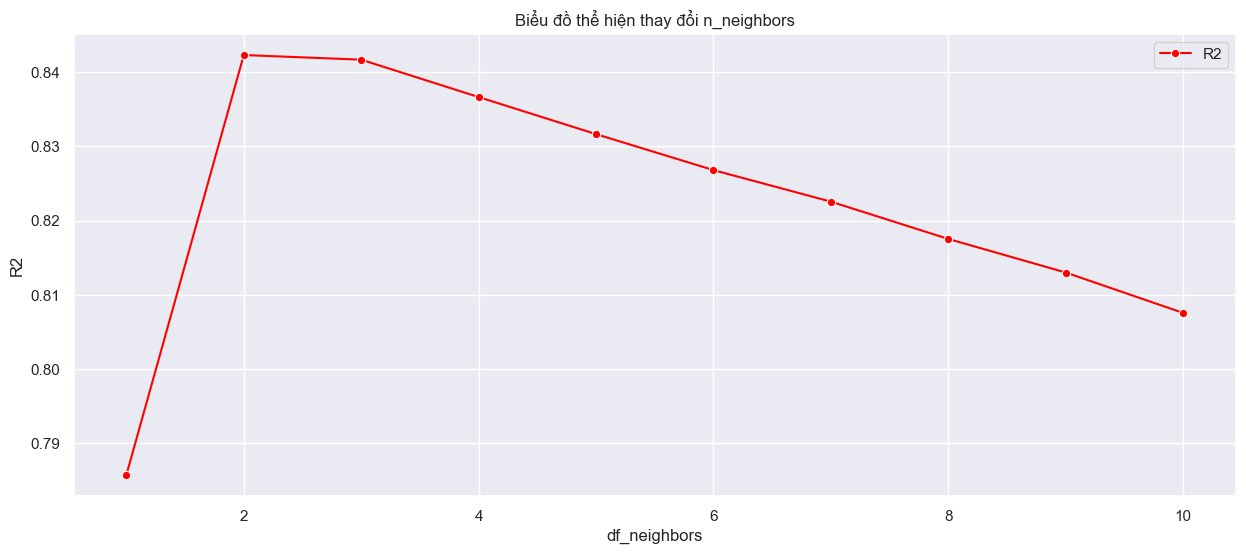

In [60]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = n_neighbors, y = df_neighbors['R2'], label = 'R2', marker = 'o', color = 'red')
plt.xlabel('df_neighbors')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.title('Biểu đồ thể hiện thay đổi n_neighbors')
plt.show()

- Chọn K = 2 vì mô hình lúc này có hiệu suất tốt nhất.

### 4.3.2 Thay đổi trọng số

In [61]:
knr1 = KNeighborsRegressor(n_neighbors = 2, leaf_size = 5, p = 2, metric = 'minkowski', weights = 'distance')
knr1.fit(x_train, y_train)
y_predict = knr1.predict(x_test)
model_evaluation('KNeighborsRegressor', y_test, y_predict).head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
0,KNeighborsRegressor,0.845216,800.374068,1.439725e+06,0.118397,1199.885236


- Mô hình được cải thiện hơn khi thay đổi các trọng số.

### 4.3.3 Thay đổi chiều dữ liệu

In [62]:
ft = ['n_components', 'R2', 'MAE', 'MSE', 'MAPE', 'RMSE']
df_components = pd.DataFrame(columns = ft)
n_components = range(10, 22)
for i in n_components:
    pca = PCA(n_components = i)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    knr = KNeighborsRegressor(n_neighbors = 2, leaf_size = 5, p = 2, metric = 'minkowski', weights = 'distance')
    knr.fit(x_train_pca, y_train)
    y_predict = knr.predict(x_test_pca)
    R2 = r2_score(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    mape = mean_absolute_percentage_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    new_record = {'n_components': i, 'R2': R2, 'MAE': mae, 'MSE': mse, 'MAPE': mape, 'RMSE': rmse}
    df_components.loc[len(df_components)] = new_record
df_components.head(12)

,n_components,R2,MAE,MSE,MAPE,RMSE
0,10,0.662562,1259.124729,3.138683e+06,0.198048,1771.632850
1,11,0.676394,1233.666703,3.010018e+06,0.195237,1734.940473
2,12,0.688349,1138.140232,2.898827e+06,0.169146,1702.594216
3,13,0.841856,804.141777,1.470981e+06,0.117982,1212.839880
4,14,0.845706,794.062423,1.435167e+06,0.116506,1197.984699
5,15,0.844948,799.631449,1.442220e+06,0.118274,1200.924637
6,16,0.845174,799.924946,1.440113e+06,0.118296,1200.047072
7,17,0.844734,800.956555,1.444212e+06,0.118468,1201.753721
8,18,0.845011,799.670982,1.441633e+06,0.118250,1200.680271
9,19,0.845806,798.022374,1.434236e+06,0.118031,1197.596058


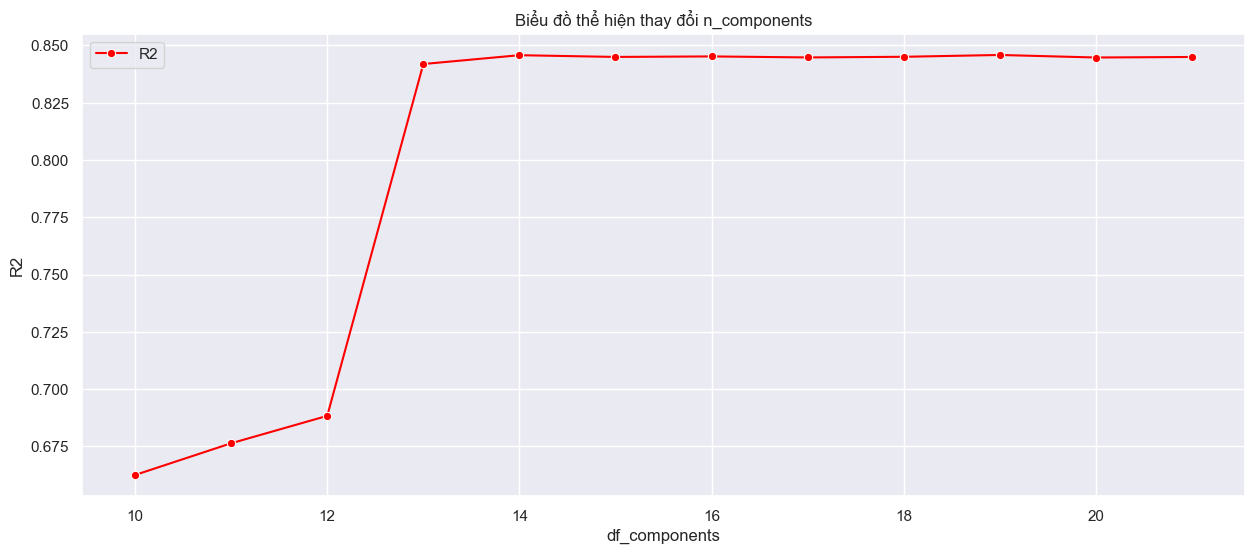

In [63]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = n_components, y = df_components['R2'], label = 'R2', marker = 'o', color = 'red')
plt.xlabel('df_components')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.title('Biểu đồ thể hiện thay đổi n_components')
plt.show()

- Với n_component = 19 mô hình hoạt động tốt nhất.

### 4.3.4 Mô hình cuối cùng

In [64]:
pca = PCA(n_components = 19)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
explain = pca.explained_variance_ratio_
knr = KNeighborsRegressor(n_neighbors = 2, leaf_size = 5, p = 2, metric = 'minkowski', weights = 'distance')
knr.fit(x_train_pca, y_train)
y_predict = knr.predict(x_test_pca)
knn_results = model_evaluation('K-Nearest Neighbors Regressor', y_test, y_predict)
model_results = pd.concat([model_results, knn_results], ignore_index = True)
knn_results.head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
0,K-Nearest Neighbors Regressor,0.845806,798.022374,1.434236e+06,0.118031,1197.596058


## 4.4 Mô hình Random Forest Regression

### 4.4.1 Mô hình thô

In [65]:
reg = RandomForestRegressor(random_state=42)
reg.fit(x_train, y_train)
y_predict = reg.predict(x_test)
model_evaluation('Random Forest Regressor', y_test, y_predict).head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
0,Random Forest Regressor,0.928165,546.916295,668174.461611,0.081608,817.419392


- Xếp hạng mức quan trọng của các đặc trưng do Random Forest xếp loại.

In [104]:
feature_importance = pd.DataFrame(x_train.columns)
feature_importance = pd.concat([feature_importance, pd.Series(reg.feature_importances_)], axis=1)
feature_importance.columns = ['Feature', 'Importance']
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = False)
feature_importance.head(21)

,Feature,Importance
14,MeanCustomers,0.474294
9,Promo,0.153027
3,CompetitionDistance,0.053697
1,StoreType,0.038420
16,DayOfWeekCos,0.037014
20,MonthCos,0.036823
0,Store,0.032378
15,DayOfWeekSin,0.032094
18,DayCos,0.027746
17,DaySin,0.025548


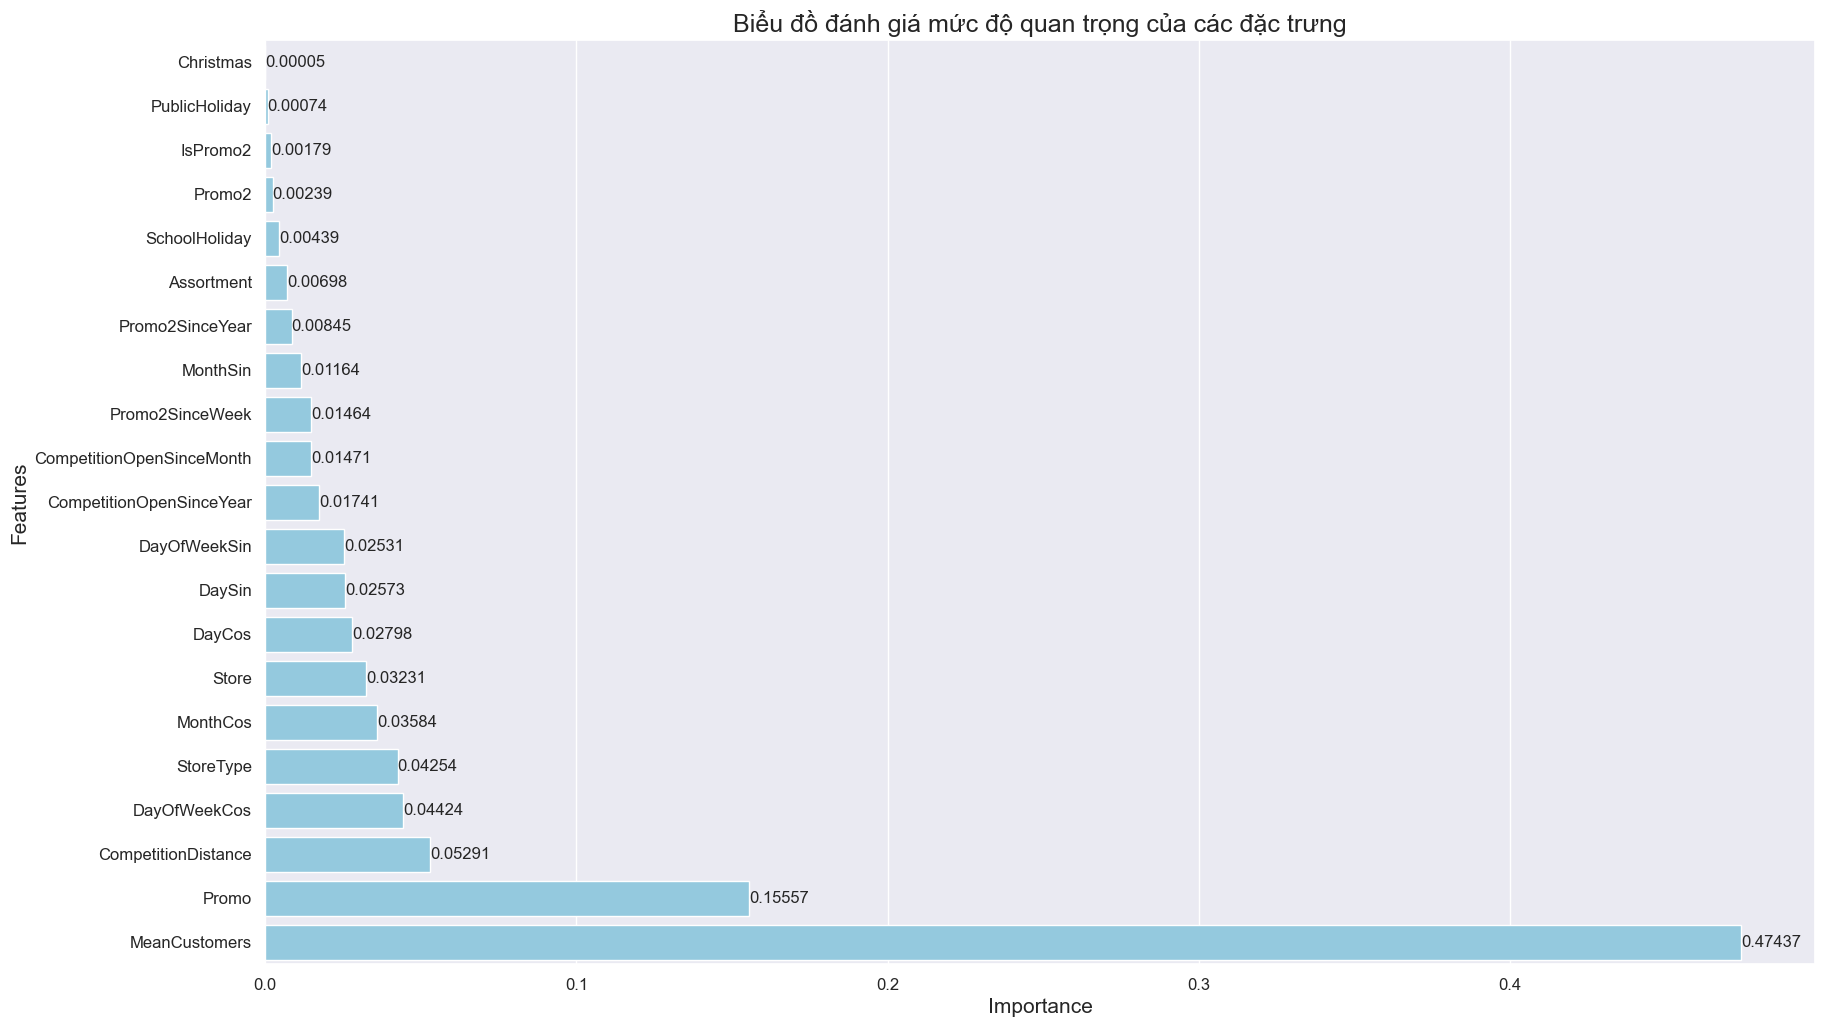

In [67]:
plt.figure(figsize = (20, 12))
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = True)
sns.barplot(x = feature_importance['Importance'], y = feature_importance['Feature'], color = 'skyblue')
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.5f}', va = 'center', ha = 'left', fontsize=12)
plt.xticks(fontsize = 12)
plt.xlabel('Importance', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Features', fontsize = 15)
plt.title('Biểu đồ đánh giá mức độ quan trọng của các đặc trưng', fontsize = 18);

### 4.4.2 Mô hình có điều chỉnh thông số

#### 4.4.2.1 Điều chỉnh n_estimators

In [68]:
ft = ['n_estimators', 'R2', 'MAE', 'MSE', 'MAPE', 'RMSE']
df_estimators = pd.DataFrame(columns = ft)
estimators = [60, 80, 100, 120, 140]
for i in estimators:
    reg = RandomForestRegressor(n_estimators = i, n_jobs= 7, random_state=42)
    reg.fit(x_train, y_train)
    y_predict = reg.predict(x_test)
    R2 = r2_score(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    mape = mean_absolute_percentage_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    new_record = {'n_estimators': i, 'R2': R2, 'MAE': mae, 'MSE': mse, 'MAPE': mape, 'RMSE': rmse}
    df_estimators.loc[len(df_estimators)] = new_record
df_estimators.head()

,n_estimators,R2,MAE,MSE,MAPE,RMSE
0,60,0.927481,550.050603,674540.507390,0.082069,821.304150
1,80,0.927913,548.376465,670515.862865,0.081826,818.850330
2,100,0.928165,546.916295,668174.461611,0.081608,817.419392
3,120,0.928333,546.153250,666612.072701,0.081497,816.463148
4,140,0.928421,545.614151,665789.988596,0.081405,815.959551


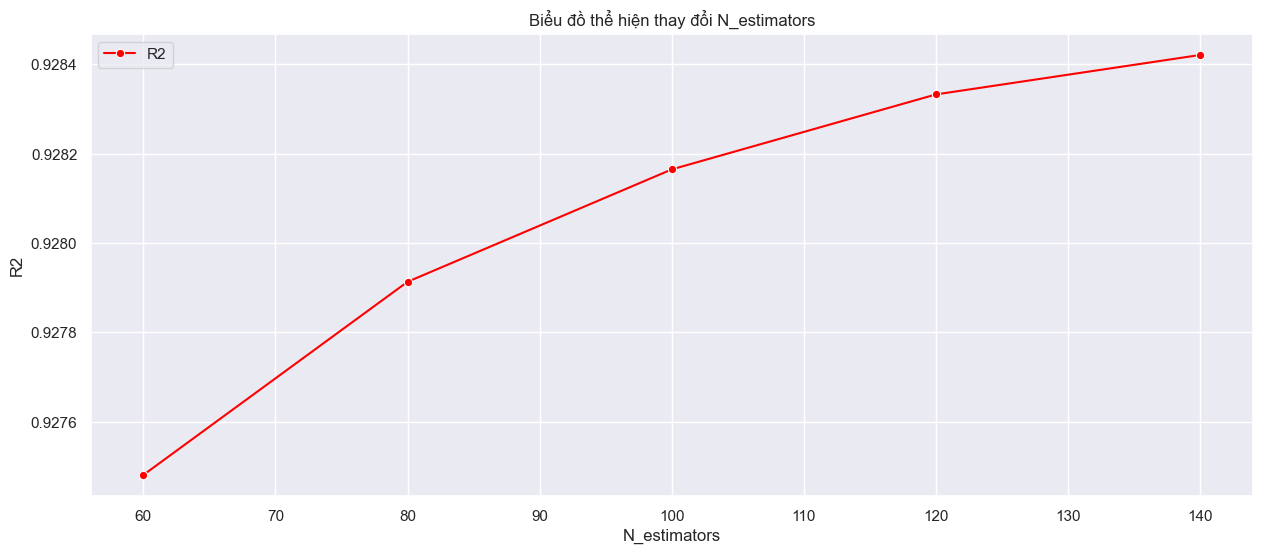

In [69]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = estimators, y = df_estimators['R2'], label = 'R2', marker = 'o', color = 'red')
plt.xlabel('N_estimators')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.title('Biểu đồ thể hiện thay đổi N_estimators')
plt.show()

- Ta thấy mô hình càng được cải thiện khi tăng số lượng cây, nhưng vì hạn chế tài nguyên nên tôi chỉ dừng lại với n_estimators = 140.

#### 4.4.2.2 Điều chỉnh max_depth, min_samples_split, max_leaf_nodes bằng RandomizedSearchCV

In [71]:
param_space = { 
    'max_depth': [33, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    }
reg = RandomForestRegressor(n_estimators = 140, random_state = 42)
rcv = RandomizedSearchCV(
    reg,
    param_space,
    n_iter = 20,
    cv = 3,
    n_jobs = 6,
    verbose = 2,
    scoring = 'neg_mean_squared_error')
rcv.fit(x_train, y_train)
print("Thông số tối ưu nhất: ", rcv.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Thông số tối ưu nhất:  {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}


In [72]:
reg = RandomForestRegressor(n_estimators = 140, max_depth = 36, min_samples_leaf = 1, min_samples_split = 2, random_state=42)
reg.fit(x_train, y_train)
y_predict = reg.predict(x_test)
model_evaluation('Random Forest Regressor', y_test, y_predict).head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
0,Random Forest Regressor,0.928472,545.454151,665321.390701,0.081396,815.672355


#### 4.4.2.3 Điều chỉnh max_feature

In [81]:
ft = ['n_features', 'R2', 'MAE', 'MSE', 'MAPE', 'RMSE']
df_features = pd.DataFrame(columns = ft)
n_features = [7, 9, 10, 11, 13, 15, 16, 18, 20]
for i in n_features:
    reg = RandomForestRegressor(n_estimators = 140, max_depth = 36, min_samples_leaf = 1, min_samples_split = 2, max_features = i, n_jobs= 7, random_state=42)
    reg.fit(x_train, y_train)
    y_predict = reg.predict(x_test)
    R2 = r2_score(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    mape = mean_absolute_percentage_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    new_record = {'n_features': i, 'R2': R2, 'MAE': mae, 'MSE': mse, 'MAPE': mape, 'RMSE': rmse}
    df_features.loc[len(df_features)] = new_record
df_features.head(9)

,n_features,R2,MAE,MSE,MAPE,RMSE
0,7,0.927223,549.940103,676937.783498,0.082091,822.762289
1,9,0.928701,544.268275,663189.061718,0.081191,814.364207
2,10,0.929496,542.192133,655795.696727,0.080927,809.812137
3,11,0.929509,541.170938,655675.273872,0.080765,809.737781
4,13,0.929692,540.719331,653967.154380,0.080698,808.682357
5,15,0.929857,540.483573,652439.331426,0.080661,807.737167
6,16,0.929862,540.034922,652393.171411,0.080565,807.708593
7,18,0.929388,541.488053,656794.522917,0.080810,810.428604
8,20,0.928880,544.009887,661522.283515,0.081162,813.340202


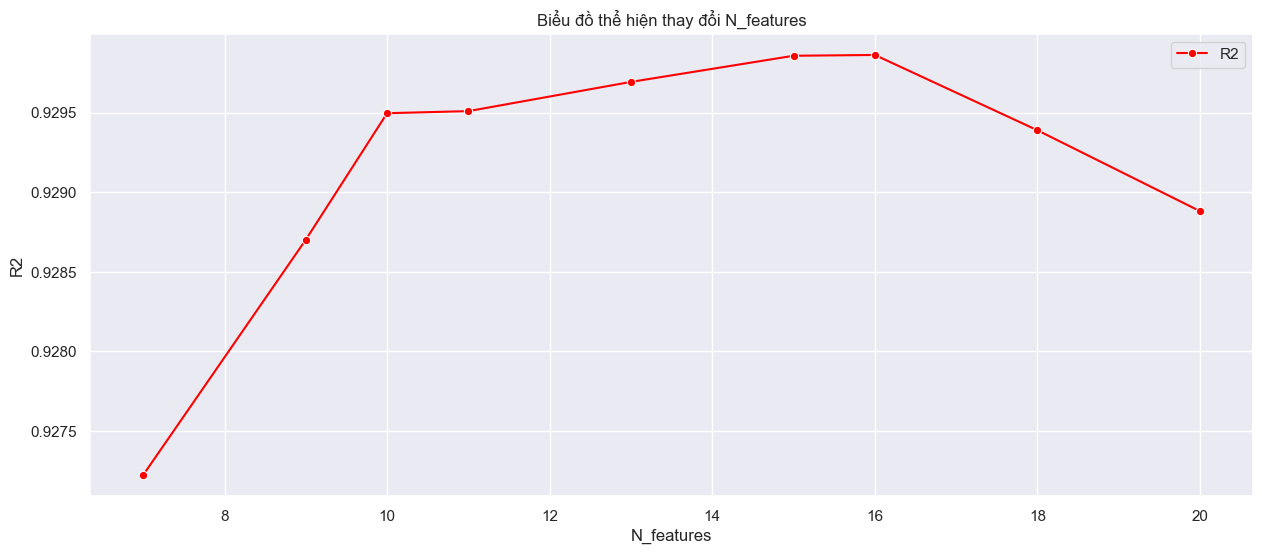

In [82]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = n_features, y = df_features['R2'], label = 'R2', marker = 'o', color = 'red')
plt.xlabel('N_features')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.title('Biểu đồ thể hiện thay đổi N_features')
plt.show()

- Mô hình đặt hiệu quả cao nhất khi max features = 16.

### 4.4.3 Mô hình cuối cùng

In [83]:
reg = RandomForestRegressor(n_estimators = 140, max_depth = 40, min_samples_leaf = 1, min_samples_split = 2, max_features = 16, random_state=42)
reg.fit(x_train, y_train)
y_predict = reg.predict(x_test)
reg_results = model_evaluation('Random Forest Regression', y_test, y_predict)
model_results = pd.concat([model_results, reg_results], ignore_index = True)
reg_results.head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
0,Random Forest Regression,0.929862,540.034922,652393.171411,0.080565,807.708593


## 4.5 Kết luận

In [87]:
model_results.sort_values(by=['R2', 'MAE', 'MSE', 'MAPE', 'RMSE'], ascending=[False, True, True, True, True]).head()

,Model Name,R2,MAE,MSE,MAPE,RMSE
3,Random Forest Regression,0.929862,540.034922,6.523932e+05,0.080565,807.708593
2,K-Nearest Neighbors Regressor,0.845806,798.022374,1.434236e+06,0.118031,1197.596058
0,Linear Regression,0.601168,1393.369809,3.709738e+06,0.222433,1926.067967
1,Linear Regression Regularized - Lasso,0.600077,1394.956519,3.719889e+06,0.222561,1928.701419


- Trực quan hóa kết quả dự đoán của mô hình có hiệu suất cao nhất: Random Forest Regression

In [100]:
df_y_test = pd.DataFrame(y_test, columns = ['Sales'])
df_SalesPredict = pd.DataFrame(y_predict, columns = ['SalesPredict'])

df_date = x_test.reset_index()

df_EDA = pd.concat([df_date['Date'], df_y_test, df_SalesPredict], axis = 1)

In [101]:
df_EDA.sort_values(by = 'Date')
df_EDA.set_index('Date', inplace = True)

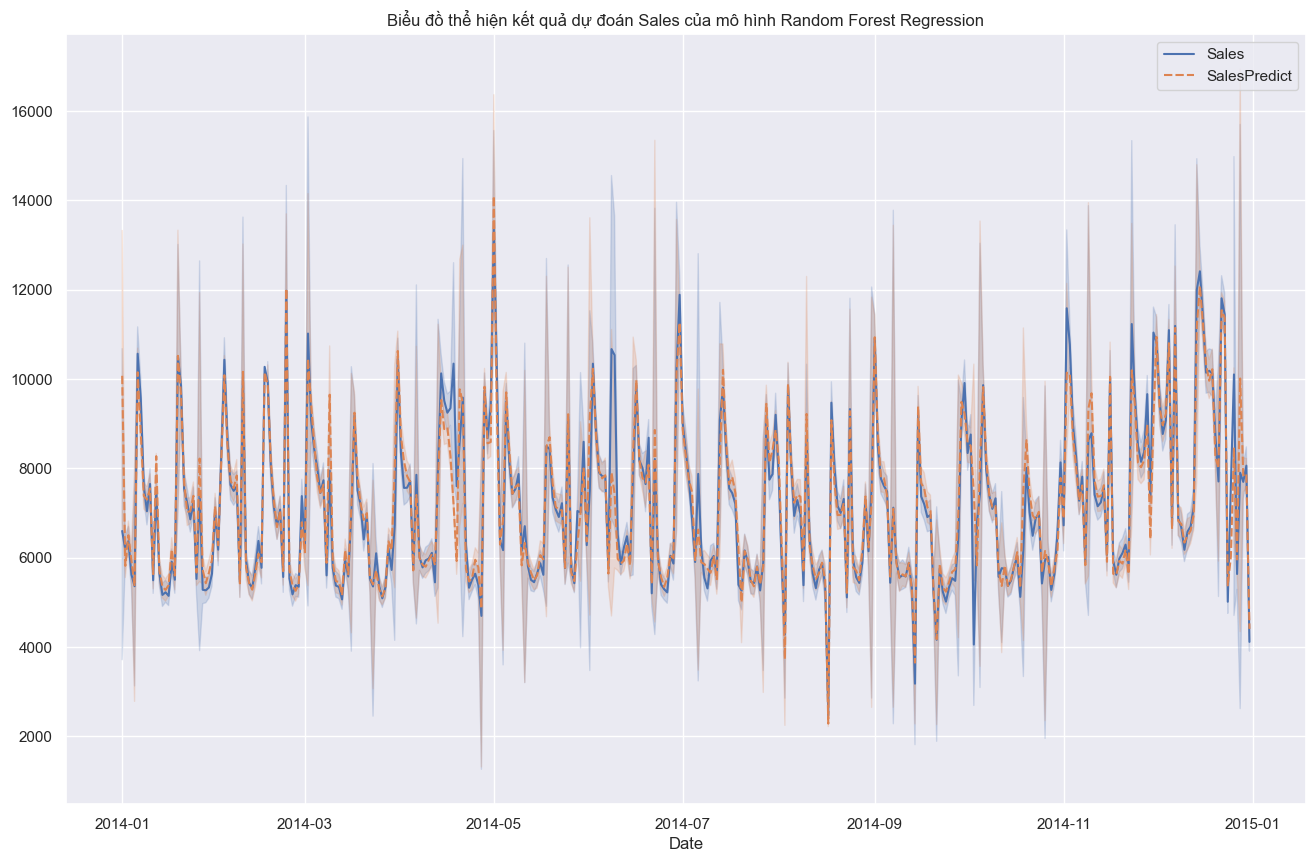

In [102]:
plt.figure(figsize=(16, 10))
sns.lineplot(data = df_EDA).set(title='Biểu đồ thể hiện kết quả dự đoán Sales của mô hình Random Forest Regression');
plt.show()